Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the movies dataset
movies = pd.read_csv('movies.csv')

# Load the ratings dataset
ratings = pd.read_csv('ratings.csv')

Load dataset

In [2]:
# Explore the movies dataset
print("Movies dataset:")
print(movies.head())
print(movies.info())
print(movies.describe())

# Check for missing values in the movies dataset
print("Missing values in movies dataset:")
print(movies.isnull().sum())

# Explore the ratings dataset
print("Ratings dataset:")
print(ratings.head())
print(ratings.info())
print(ratings.describe())

# Check for missing values in the ratings dataset
print("Missing values in ratings dataset:")
print(ratings.isnull().sum())

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
             movieId
count    9742.000000

Explore the data

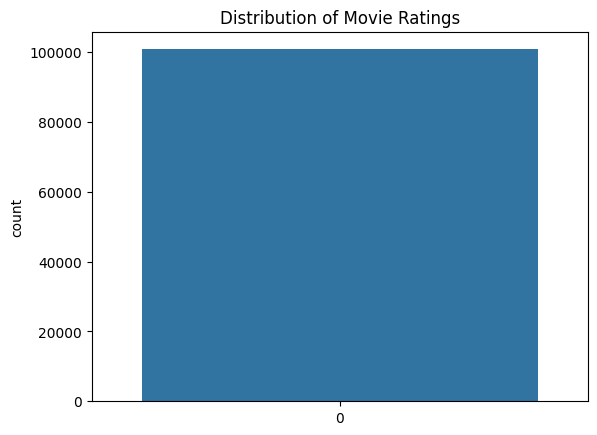

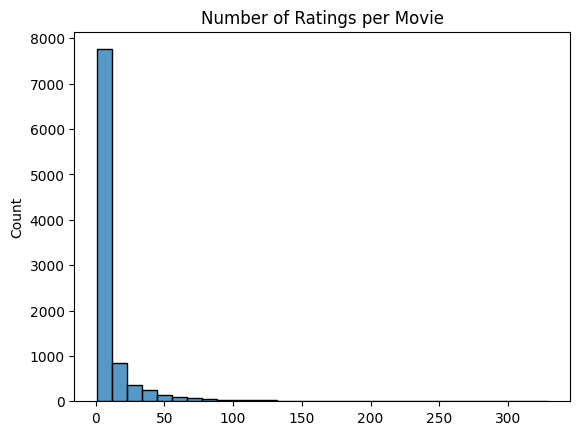

In [3]:
# Visualize the distribution of movie ratings
sns.countplot(ratings['rating'])
plt.title('Distribution of Movie Ratings')
plt.show()

# Visualize the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()
sns.histplot(ratings_per_movie, bins=30, kde=False)
plt.title('Number of Ratings per Movie')
plt.show()

# Create the user-item matrix

In [4]:
# Create the user-item matrix
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
print(user_item_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

Split the Data

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Create the user-item matrix for the training set
train_matrix = train.pivot_table(index='userId', columns='movieId', values='rating')

# Create the user-item matrix for the test set
test_matrix = test.pivot_table(index='userId', columns='movieId', values='rating')


 Collaborative Filtering

In [6]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156248 sha256=afd54f404baefd708d684f039e7b8d788b592973e8d468073fa2bc5fceaba871
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [7]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

# Define the reader and the data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.2)

# Define the user-based collaborative filtering model
sim_options = {'name': 'pearson', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

# Fit the model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Calculate and print the RMSE
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9700
RMSE: 0.9700265809314357


Content-Based Filtering

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Preprocess the movie genres
movies['genres'] = movies['genres'].fillna('').apply(lambda x: x.replace('|', ' '))

# Define a TF-IDF Vectorizer object to convert genres to feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the genres
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Build a mapping of movie titles to indices
indices = pd.Series(movies.index, index=movies['title']).to_dict()


Build and Evaluate the Model

In [9]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with the input movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    movie_indices = [i[0] for i in sim_scores[1:11]]

    # Return the titles of the 10 most similar movies
    return movies['title'].iloc[movie_indices]


Tune the Model

In [10]:
from surprise import accuracy

# Calculate and print the RMSE for collaborative filtering
rmse = accuracy.rmse(predictions)
print(f'RMSE for collaborative filtering: {rmse}')


RMSE: 0.9700
RMSE for collaborative filtering: 0.9700265809314357


In [11]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'k': [10, 20, 30],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False],
    }
}

# Instantiate the grid search object
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5)

# Fit the grid search object
gs.fit(data)

# Get the best parameters and model
best_params = gs.best_params
best_model = gs.best_estimator['rmse']

# Print the best parameters and RMSE
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {gs.best_score["rmse"]}')


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

Build a Hybrid Model

In [12]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with the input movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    movie_indices = [i[0] for i in sim_scores[1:11]]

    # Return the titles of the 10 most similar movies
    return movies['title'].iloc[movie_indices]

def hybrid_recommendations(userId, title, ratings, movies, indices, model, cosine_sim=cosine_sim):
    # Ensure the user and movie exist in the data
    if userId not in ratings['userId'].unique():
        return f'Error: userId {userId} does not exist.'
    if title not in movies['title'].unique():
        return f'Error: title {title} does not exist.'

    # Get the content-based recommendations
    content_based_recommendations = get_recommendations(title, cosine_sim)

    # Get the movieIds of the content-based recommendations
    movieIds = []
    for movie in content_based_recommendations:
        if movie in indices:
            movieIds.append(indices[movie])
        else:
            print(f"Warning: '{movie}' not found in indices dictionary")

    # Check if user has ratings in the system
    if ratings[ratings['userId'] == userId].shape[0] == 0:
        return f'Error: User {userId} has no ratings in the system.'

    # Get the collaborative filtering predictions
    cf_predictions = [model.predict(userId, movieId).est for movieId in movieIds]

    # Combine the content-based and collaborative filtering predictions
    hybrid_scores = [(movie, cf_predictions[i]) for i, movie in enumerate(content_based_recommendations)]
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)

    # Return the top 10 recommendations
    return [movie[0] for movie in hybrid_scores[:10]]


Final

In [13]:
# Define the user ID and the movie title
userId = 5
title = "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"

# Get the hybrid recommendations
recommendations = hybrid_recommendations(userId, title, ratings, movies, indices, model)

# Print the recommendations
print(recommendations)


['Indian in the Cupboard, The (1995)', 'NeverEnding Story, The (1984)', 'NeverEnding Story III, The (1994)', 'Escape to Witch Mountain (1975)', 'NeverEnding Story II: The Next Chapter, The (1990)', 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)', 'Santa Claus: The Movie (1985)', "Darby O'Gill and the Little People (1959)", 'Return to Oz (1985)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"]
